In [1]:
pip install geomdl

     |████████████████████████████████| 147 kB 14.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import math
import dlib
import sys
from scipy.spatial import distance
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image, ImageDraw
sys.path.append("/work/Particle_Filter/circle_finder_main/circle_finder_main")
from circle_finder.csf import CircularSeparabilityFilter
from circle_finder.torch import EllipticalSeparabilityFilter
sys.path.append("/work/Particle_Filter")
from particle_fileter_main.test_1 import ParticleFilter
from contour_extraction.test_0 import clac_contour_iris
from contour_extraction.test_1 import Contour_Iris
from Siamese_Network.test_5 import Eye_open_rate
from imutils import face_utils
sys.path.append("/work/Particle_Filter/SnakeLib")
from geomdl.fitting import approximate_curve
from SnakeLib import MultiSeparabilitySnake as mss
import time

#楕円形分離度フィルタ
def a(img,a,b,c,d):
    axes_in = a,b
    axes_out = c,d
    angle = 0
    esf = EllipticalSeparabilityFilter(axes_in,axes_out,angle)
    epmap,circles = esf.find_circles(img, num_circles=5)   #num_circlesの適切値は？？
    cut_img = esf.cut_img_4(img,circles)     #カットできない画像は黒画像が返される
    rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return epmap,cut_img,circles
#中心座標を用いて、指定サイズにトリミング
def cut_img(img,center,size):
    x = int(size[0]/2)
    y = int(size[1]/2)
    a= int(center[0])
    b= int(center[1])
    data = img[b-y:b+y,a-x:a+x]
    return data
#開眼度の計算1
def calc_ear(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    eye_ear = (A + B) / (2.0 * C)
    return round(eye_ear, 3)
#開眼度の計算2
def calc_ratio(img,radius):
    im_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    iris_outline = np.argwhere(im_gray==255)
    x = iris_outline[:,1]
    x = np.unique(x)
    length_max = 0
    for i in x:
        try:
            y_index = np.argwhere(iris_outline[:,1] == i)
            y = iris_outline[y_index,0]
            y_mean = np.mean(y)
            y_up = np.max(y[y<y_mean])
            y_down = np.min(y[y>y_mean])
            length = y_down-y_up
            if length_max < length:
                length_max = length
            #print(f"i:{i}の時 , length_max/(radius*2):{length_max/(radius*2)}")
        except ValueError as e:
            #print(f"radius:{round(radius,3)}, {x[0]}から{x[-1]+1}の横軸において:{i}, Error：{e}")
            pass
    return round(length_max/(radius*2),3)
#虹彩の中心座標と虹彩半径の計算
def eye_center(eye):
    A = (eye[1]+eye[4])
    B = (eye[2]+eye[5])
    position = (A + B) / 4
    C = distance.euclidean(eye[1],eye[4])
    D = distance.euclidean(eye[2],eye[5])
    radius = (C + D ) / 4   #目をつぶったとき分離度マップはどうなる？？
    return position,radius
#右目ランドマークのプロット
def plot_landmark(numpy_img,landmark):
    for index,(x,y) in enumerate(landmark,start=36):
        x = landmark[index][0]
        y = landmark[index][1]
        if(index==42):break
        else:cv.circle(numpy_img, (x, y), 5, (255, 255, 0), -1)
    return numpy_img
#トリミングするサイズの計算
def calc_size(eye):
    A = distance.euclidean(eye[0], eye[3])*2
    B = distance.euclidean(eye[1], eye[4])
    C = distance.euclidean(eye[2], eye[5])
    D = (B + C)
    size = (int(A),int(D))
    return size

In [11]:
def tracking():
    start = time.time()
    #初期設定
    path = "/work/Particle_Filter/Siamese_Network/video/Bright_40cm.mp4"
    cap = cv.VideoCapture(path)
    size = (1080,1920) #元画像のサイズ
    filter_eye_left = ParticleFilter(size)
    filter_eye_left.initialize() #パーティクルフィルタ初期化    
    x,y,z = 0,0,0
    flag = True
    img_left,img_right,img_3,img_4,img_5,img_6,img_7,img_8,eye_left_opening_rate = [],[],[],[],[],[],[],[],[]
    img_4 = []
    alpha,beta = 0,0
    threshold = 0   #得たいフレームの開始番号    
    face_detector = dlib.get_frontal_face_detector()    # 顔検出ツールの呼び出し
    predictor_path = '/work/Particle_Filter/particle_fileter_main/shape_predictor_68_face_landmarks.dat'
    face_predictor = dlib.shape_predictor(predictor_path)
    #各フレームに対して虹彩の輪郭を求める
    while flag:
        if x<threshold:
            ret, img_1 = cap.read()
            x+=1
        if x>threshold or x ==threshold:
            ret, img_1 = cap.read()   
            if x%50==0:
                print(str(x)+"枚目の画像の追跡")
            #print(str(x)+"枚目の画像の追跡") 
            x+=1
            #ランドマークの抽出
            if(cap.isOpened()==True and img_1 is not None):#Trueが返されたら動画読み込みOK
                test_img = img_1.copy()#引数用
                draw_img = img_1.copy()#描画用
                img_gry = cv.cvtColor(test_img, cv.COLOR_BGR2GRAY)
                faces = face_detector(img_gry, 1)
                for face in faces:#検出した顔の数だけfor文を回す
                    landmark = face_predictor(img_gry, face)
                    landmark = face_utils.shape_to_np(landmark)# 処理高速化のためランドマーク群をNumPy配列に変換(必須)     
                    center,radius = eye_center(landmark[36:42])#虹彩の中心と分離度フィルタの半径を得る
                    size = calc_size(landmark[36:42]) #ここでトリミングするサイズが決まる！！
                    width,height =  size[0],size[1]
                    x_before,y_before = size[0]/2,size[1]/2
                    #draw_img =  plot_landmark(draw_img,landmark)#左目のランドマークをplot
                    #print(f"size:{size}/radius:{radius}/center:{center}/")
            else:
                x+=1
                continue
            #ランドマークの判別処理
            if (landmark is not None):
                center_eye_left = center[0],center[1]#全体の状態での座標
                center_eye_left_x,center_eye_left_y = center[0],center[1]
            else:
                center_eye_left = [center_eye_left_x,center_eye_left_y]#radiusは1フレーム前のものを採用する
            #虹彩の中心座標を求める
            img_eye_left = cut_img(img_1,center_eye_left,size)#左の瞳付近をトリミング
            y_after, x_after = filter_eye_left.filtering(img_eye_left, radius, width,height)#瞳の中心座標の推定値を取得
            
            #全体画像に対して虹彩の中心座標をプロット
            alpha = x_after - x_before
            beta = y_after - y_before
            center_eye_left_x_1 = center_eye_left_x+alpha
            center_eye_left_y_1 = center_eye_left_y+beta
            cv.circle(draw_img,center=(int(center_eye_left_x_1), int(center_eye_left_y_1)),radius=3,color=(255, 255, 255),thickness=-1)
            
            #虹彩輪郭の抽出
            center_eye_left_1 = center_eye_left_x_1,center_eye_left_y_1#全体画像においての虹彩の中心座標
            img_eye_left = cut_img(test_img,center_eye_left_1,size)
            img_8.append(img_eye_left)
            
            #分離度スネーク
            h,w = img_eye_left.shape[0:2]
            center = np.array([w/2 , h/2])
            radius_2 = np.array([int(radius), int(radius)])
            theta = math.radians(0)
            #print(f"h,w:{h},{w}, center:{center}, radius_2:{radius_2}, theta:{theta}")
            pts = mss.make_ellipse_points(center, radius_2, theta)
            degree = 3
            cs = 8
            rect_size = np.array([30, 8])
            curve = approximate_curve(pts.tolist(), degree, ctrlpts_size=cs)
            result_curve = mss.separability_snake(img_eye_left, curve, rect_size, dif_abs=True)
            result_pts = np.array(result_curve.evalpts).astype(np.int32)
            
            img_eye_left =mss.draw_point_to_img(result_pts, img_eye_left)
            img_eye_left = cv.cvtColor(img_eye_left , cv.COLOR_BGR2RGB)
            ratio = calc_ratio(img_eye_left,radius)
#             ear = calc_ear(landmark[36:42])
#             if ear <= 0.2 : ratio = 0
            draw_img = mss.draw_point_to_img_2(result_pts, draw_img, center_eye_left_y_1, center_eye_left_x_1, y_before, x_before)
            draw_img = cv.cvtColor(draw_img  ,cv.COLOR_BGR2RGB)
            
            #出力準備
            img_3.append(draw_img)
            img_4.append(img_eye_left)
            #img_5.append(binary)
            img_6.append(radius)
            img_7.append(test_img)
            eye_left_opening_rate.append(ratio)
            
        if x > 600:#目を閉じた後しっかり追跡できるか
            elapsed_time = time.time() - start
            print (f"elapsed_time:{round(elapsed_time,3)}[sec]")
            print("追跡を終了します")
            flag = False

    return img_3 , img_4 , img_6 , img_7 , img_8 , eye_left_opening_rate

In [ ]:
img,img_2,radius,origin,origin_iris,ratio = tracking()

0枚目の画像の追跡


In [1]:
x=10
plt.figure(figsize=(10,5))
print(f"ratio:{ratio[x]} , radius:{radius[x]}")
ori = cv.cvtColor(origin[x], cv.COLOR_BGR2RGB)
plt.imshow(ori)

NameError: name 'plt' is not defined

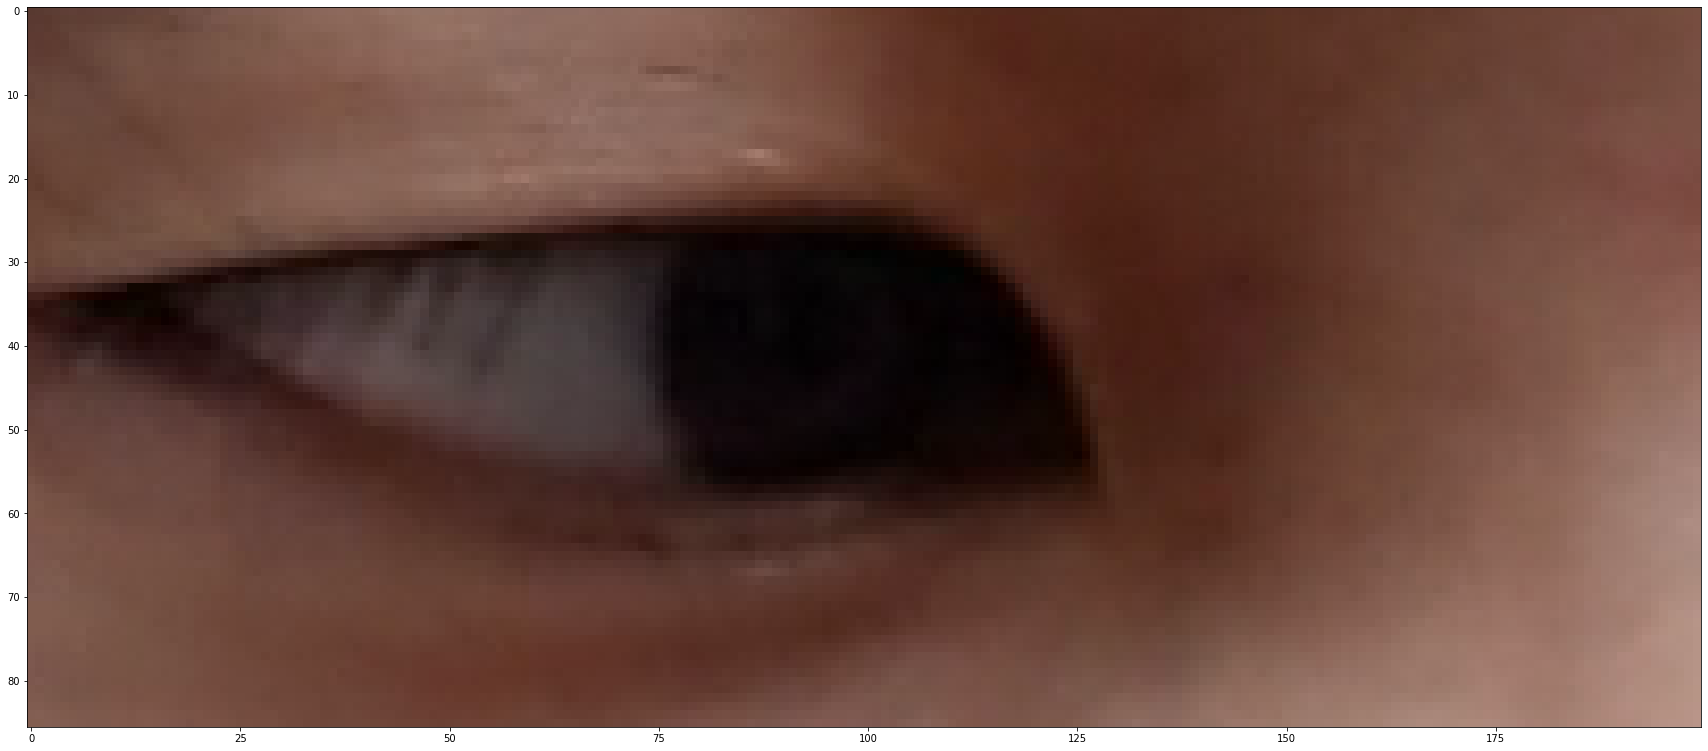

In [5]:
plt.figure(figsize=(30,20))
final = cv.cvtColor(origin_iris[x], cv.COLOR_BGR2RGB)
plt.imshow(final)

radius[10]:21.527676372585283 , ratio[10]:0.906
追跡元画像サイズ：(1080, 1920, 3)
虹彩周辺画像サイズ：(86, 200, 3)


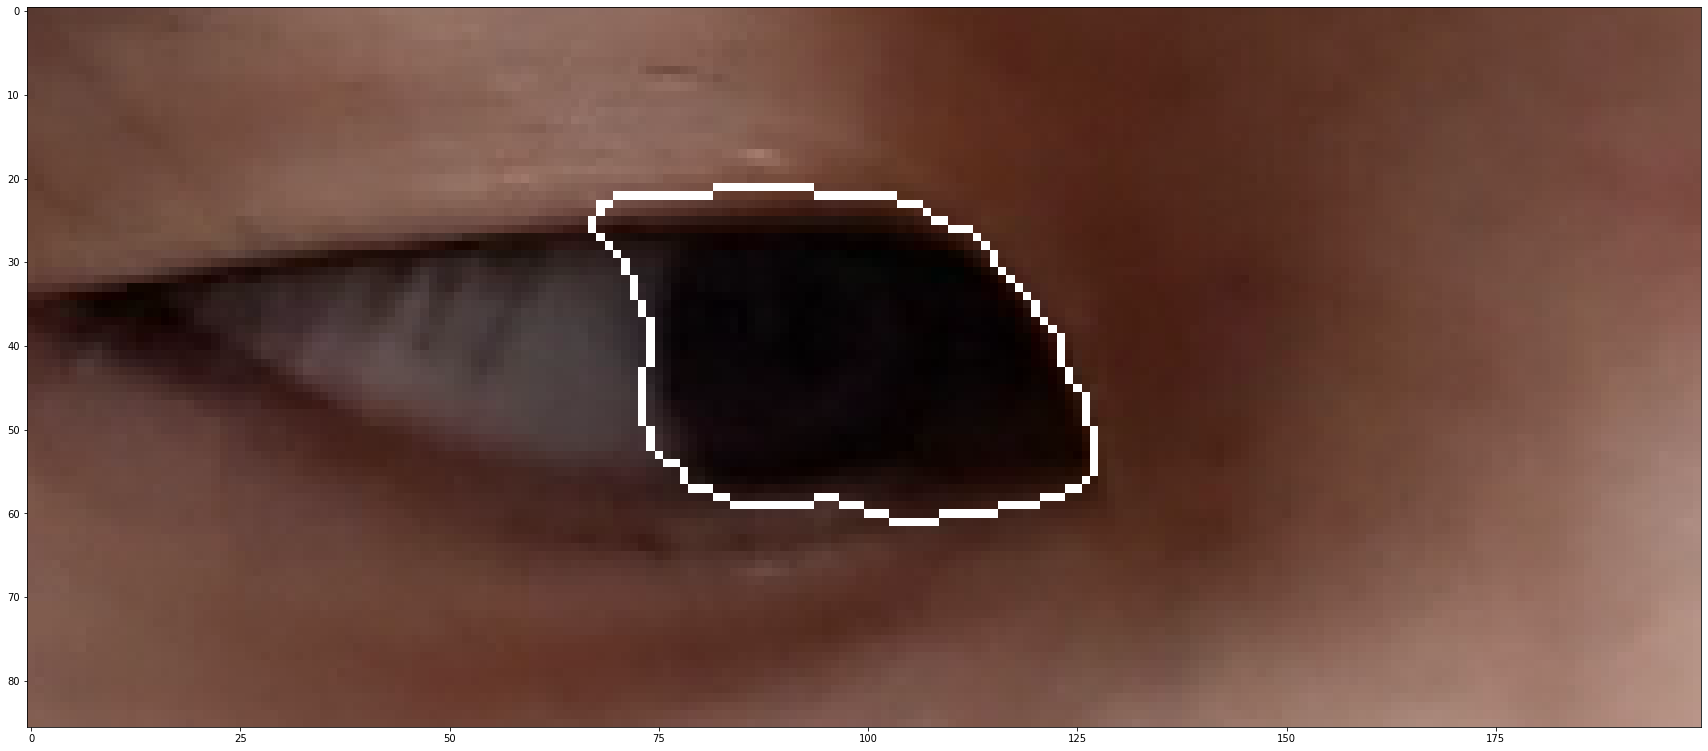

In [6]:
x = 10
print(f"radius[{x}]:{radius[x]} , ratio[{x}]:{ratio[x]}")
print(f"追跡元画像サイズ：{img[x].shape}")
print(f"虹彩周辺画像サイズ：{img_2[x].shape}")
plt.figure(figsize=(30,20))
plt.imshow(img_2[x])

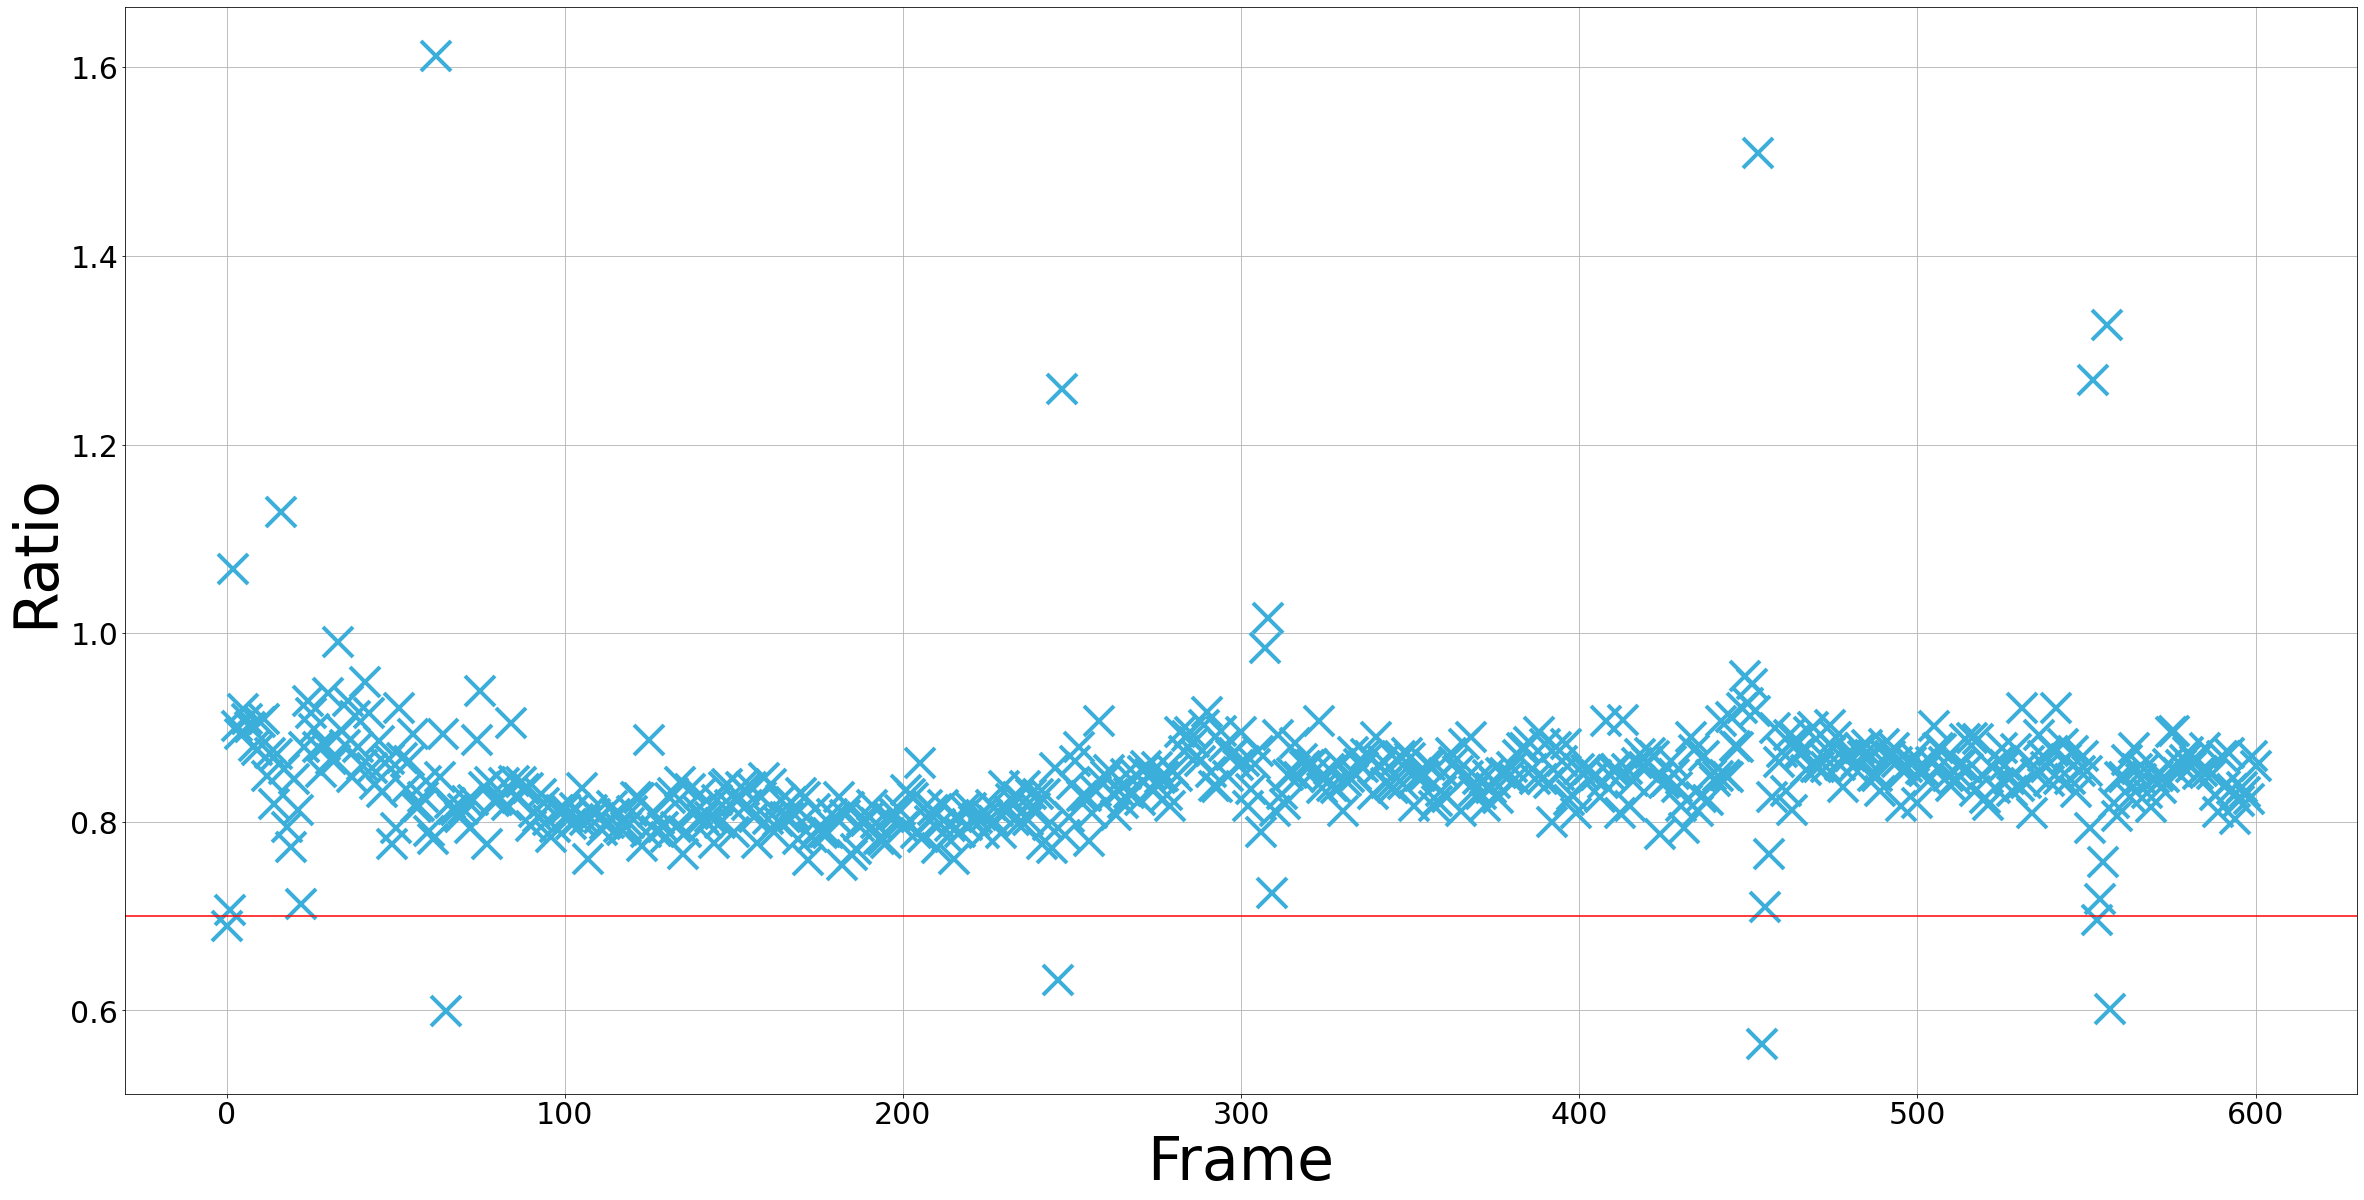

In [7]:
import pandas as pd

num = len(img)#開眼度のグラフを表示
x_1 = np.arange(num)
y_1 = np.array(ratio)
threshold = 0.7
z = (y_1<threshold)
#z = (y_1>threshold)
x_2 = np.where(z)#threshold未満を満たすインデックス
#print(x_2)

fig = plt.figure(figsize=(40,20))
#plt.plot(x_1,y_1) 
plt.plot(x_1,y_1,color="#3bafda",marker="x",markersize=30,markeredgewidth=4,linewidth=3,linestyle="None") 

plt.xlabel("Frame" ,fontsize = 60)
plt.ylabel("Ratio" ,fontsize = 60)
plt.tick_params(labelsize=30)
plt.grid()

plt.axhline(y=threshold,color='r')
plt.show()

In [8]:
print(len(x_2[0]))
print(x_2[0])

6
[  0  65 246 454 553 557]


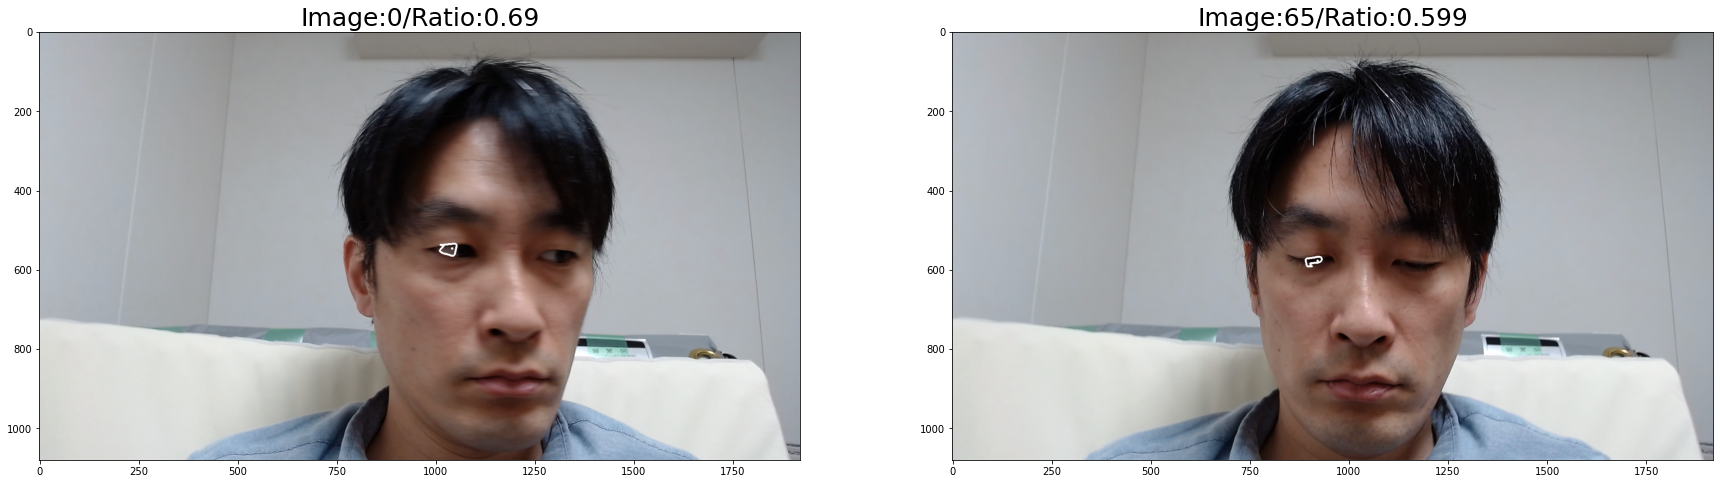

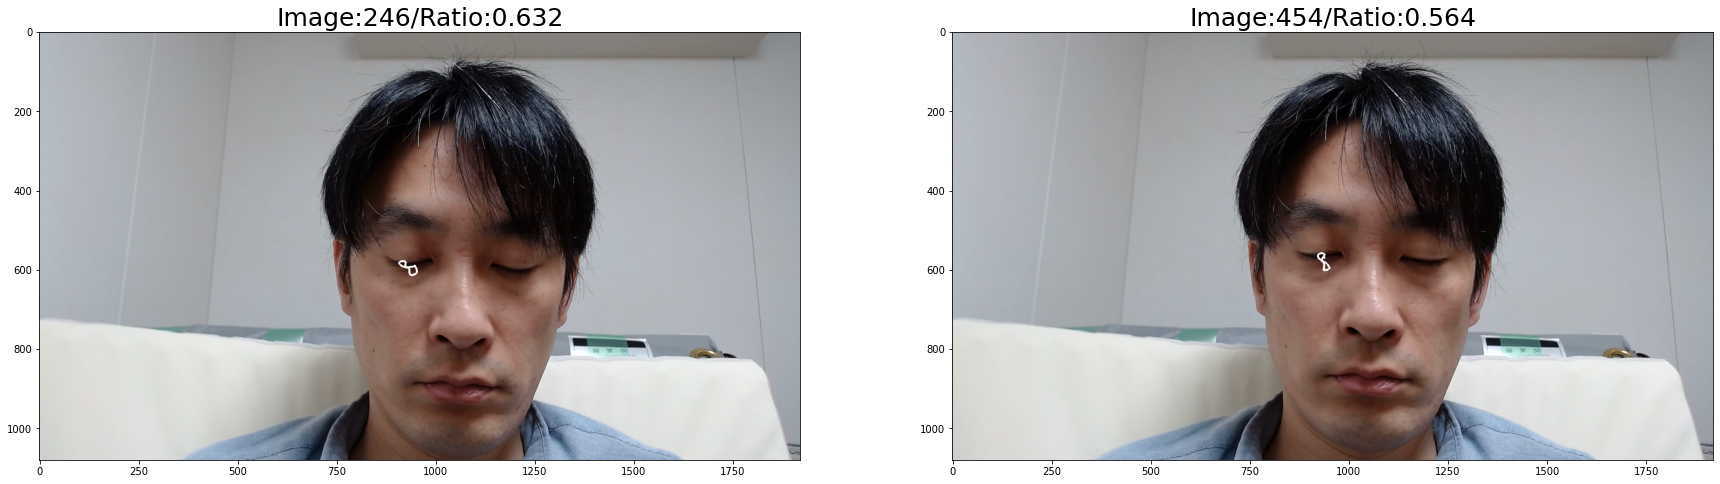

In [9]:
#開眼度の低い全体画像
num = len(x_2[0])
x=0
width = 2
# height = int(num/width)
height = 2
for m in range(height):
    plt.figure(figsize=(30,20))
    for n in range(width):
        index=n%width+1
        plt.subplot(1,width,index)
        plt.title("Image:"+str(x_2[0][x])+"/Ratio:"+str(ratio[x_2[0][x]]),fontsize=25)
        plt.imshow(img[x_2[0][x]])
        x+=1

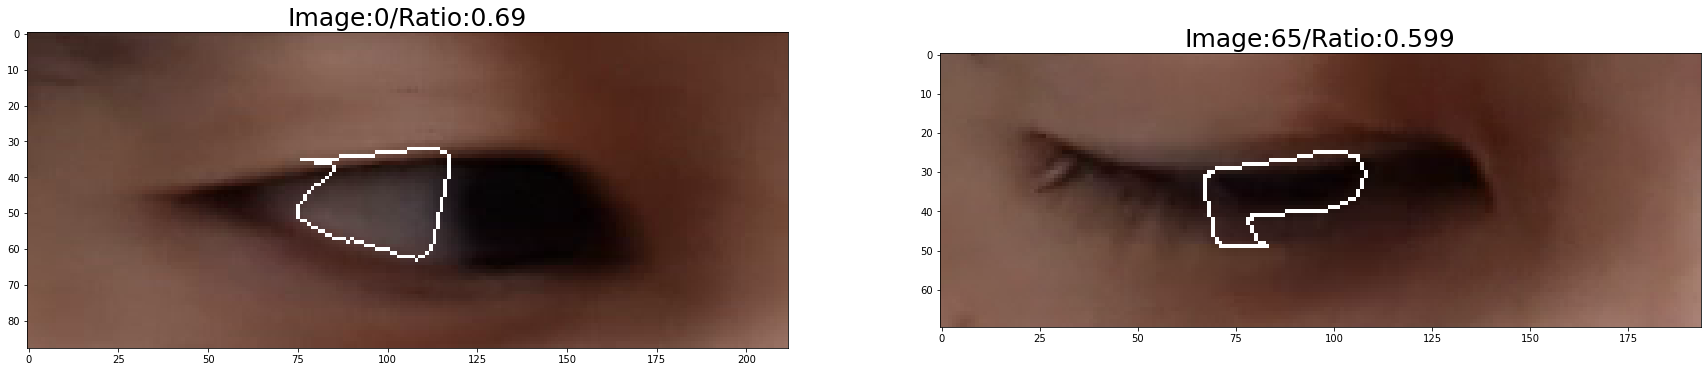

In [10]:
#開眼度の低い虹彩付近画像
num = len(x_2[0])
x=0
width = 2
# height = int(num/width)
height = 1
for m in range(height):
    plt.figure(figsize=(30,20))
    for n in range(width):
        index=n%width+1
        plt.subplot(1,width,index)
        plt.title("Image:"+str(x_2[0][x])+"/Ratio:"+str(ratio[x_2[0][x]]),fontsize=25)
        plt.imshow(img_2[x_2[0][x]])
        x+=1

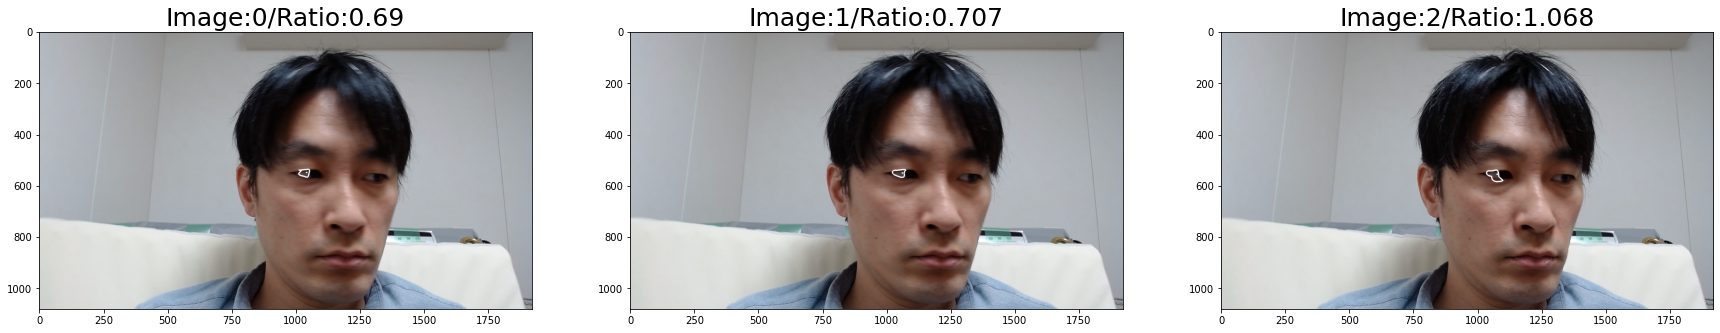

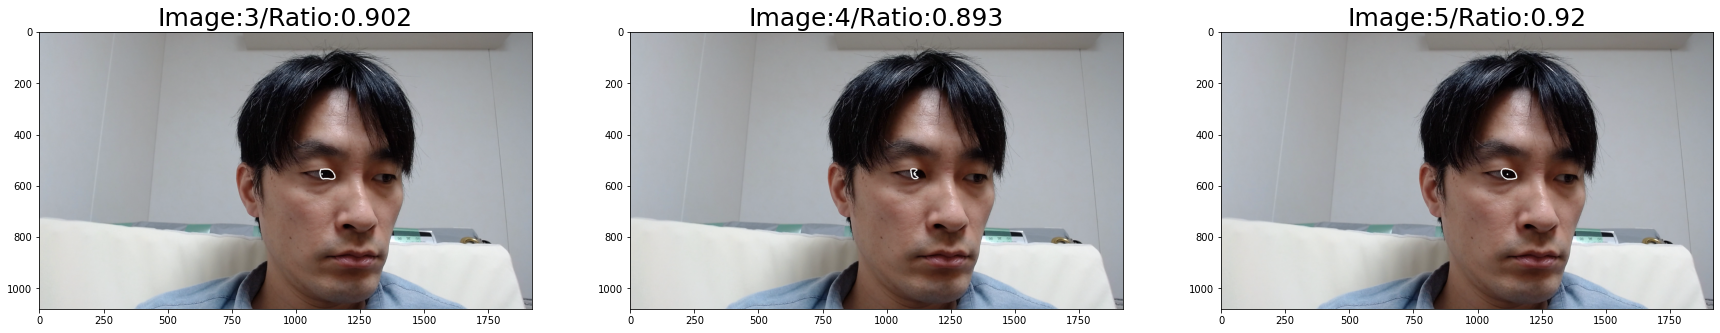

In [11]:
#画像の表示
num = len(img)#画像と開眼度を表示
x= 0
width = 3
height = 2
for m in range(height):
    plt.figure(figsize=(30,20))
    for n in range(width):
        index=n%width+1
        index_2 = x
        plt.subplot(1,width,index)
        plt.title("Image:"+str(x)+"/Ratio:"+str(ratio[x]),fontsize=25)
        plt.imshow(img[index_2])
        x+=1

In [13]:
#    ここから保存！！！     #

In [12]:
# name = "Bright_40cm"
# method = ""

In [14]:
# #グラフ保存
# fig.savefig("/work/Particle_Filter/Experiment/" + name + "/" + method + "/Figure/" + method + ".png")
# #リスト保存
# import pickle
# f = open("/work/Particle_Filter/Experiment/" + name + "/" + method + "/Ratio/" + method + ".txt", 'wb')
# list_row = ratio
# pickle.dump(list_row, f)

In [15]:
# #虹彩画像保存
# for i in range(len(img)):
#     iris = cv.cvtColor(img_2[i], cv.COLOR_BGR2RGB)
#     cv.imwrite("/work/Particle_Filter/Experiment/" + name + "/" + method + "/Iris/"+str(i)+".png", iris)
#     cv.imwrite("/work/Particle_Filter/Experiment/" + name + "/" + method + "/Origin/"+str(i)+".png",origin[i])
#     cv.imwrite("/work/Particle_Filter/Experiment/" + name + "/" + method + "/Origin_iris/"+str(i)+".png",origin_iris[i])

In [16]:
# #動画保存
# import os
# import cv2 as cv
# import numpy as np
# num = len(img)#フィルタの数
# x=0
# # 画像サイズ
# h = img[0].shape[0]
# w = img[0].shape[1]
# img_outdir = "/work/Particle_Filter/Experiment/Video/" + method +"/"
# os.makedirs(img_outdir, exist_ok=True)
# # 動画用の画像
# outimg_files = img
# # 動画作成
# fourcc = cv.VideoWriter_fourcc(*'XVID')
# video  = cv.VideoWriter(img_outdir + name + '_0.avi', fourcc, 20.0, (w, h), True)
# for x in range(num):
#     img_video = outimg_files[x]
#     img_video = cv.cvtColor(img_video, cv.COLOR_BGR2RGB)
#     video.write(img_video)
# video.release()